In [1]:
import numpy as np
import netCDF4 as nc
import xarray as xr
import matplotlib.pyplot as plt
from salishsea_tools import (nc_tools, viz_tools, gsw_calls, geo_tools)
import numpy.ma as ma
from matplotlib import animation, rc
import matplotlib.cm as cm
import scipy.signal as signal
%matplotlib inline

In [2]:
rc('animation', html='html5')

In [3]:
mesh_mask = nc.Dataset('/home/vdo/MEOPAR/NEMO-forcing/grid/mesh_mask201702.nc')
new_domain = mesh_mask.variables['tmask'][0,:,334:898,114:398]   
def calc_rho(Sal, TempC, P):
    sqrSal = np.sqrt(Sal)
    R1 = ((((6.536332e-9 * TempC - 1.120083e-6) * TempC + 1.001685e-4)
           * TempC - 9.095290e-3) * TempC + 6.793952e-2) * TempC - 28.263737
    R2 = (((5.3875e-9 * TempC - 8.2467e-7) * TempC + 7.6438e-5)
          * TempC - 4.0899e-3) * TempC + 8.24493e-1
    R3 = (-1.6546e-6 * TempC + 1.0227e-4) * TempC - 5.72466e-3
    SIG = (4.8314e-4 * Sal + R3 * sqrSal + R2) * Sal + R1
    V350P = 1.0 / 1028.1063
    SVA   = -SIG * V350P / (1028.1063 + SIG)
    rho = 28.106331 - SVA / (V350P * (V350P + SVA)) + 1000
    return rho

In [9]:
hindcast = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSn3DTracerFields1hV16-10')

In [8]:
time_slice2 = slice('2017-05-22 12:00:00', '2017-05-28 12:00:00')
x_slice = slice(115, 365)
y_slice = slice(335, 785)
sal2 = (hindcast.salinity
        .isel( gridX=x_slice, gridY=y_slice)
        .sel(time=time_slice2))
temp2 = (hindcast.temperature
         .isel(gridX = x_slice, gridY = y_slice)
         .sel(time=time_slice2))
sal_values2 = sal2.values
temp_values2 = temp2.values
print(sal_values2.shape)
print(temp_values2.shape)

NameError: name 'hindcast' is not defined

In [6]:
depth = hindcast.depth.values

In [7]:
density1 = calc_rho(sal_values2, temp_values2, depth[np.newaxis,:,np.newaxis, np.newaxis])

In [8]:
rho = 1023.3
index1 = (np.abs(density1 - rho)).argmin(axis=1)
list_of_depths1 = np.zeros((144,450,250))
for t in range(144):
    for y in range(450):
        for x in range(250):
            list_of_depths1[t,y,x] = depth[index1[t,y,x]]

In [7]:
nemo_ji = np.array([(400, 25), (350,35), (300,40), (240,120), (250,50), (200,120), (150,150), 
                    (100,170), (50,180)]) + (335,115)
grid = xr.open_dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
atmos_grid = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaAtmosphereGridV1')
winds_data = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaSurfaceAtmosphereFieldsV1')

In [8]:
time_slice = slice('2017-05-22 12:00:00', '2017-05-28 12:00:00')
N = 1
Wn = 1/24
B, A = signal.butter(N,Wn)
vwinds2 = np.zeros((9,145))
i=0
for point in nemo_ji:
    nemo_lon = grid.nav_lon.isel(y=point[0], x=point[1])
    nemo_lat = grid.nav_lat.isel(y=point[0], x=point[1])
    nemo_lon_lat = (np.asscalar(nemo_lon.values), np.asscalar(nemo_lat))
    atmos_ji = geo_tools.find_closest_model_point(
        nemo_lon_lat[0], nemo_lon_lat[1],
        atmos_grid.longitude.values - 360, atmos_grid.latitude.values,
        grid = "GEM2.5")
    u_wind_ts = (winds_data.u_wind
                 .isel(gridY=atmos_ji[0], gridX=atmos_ji[1])
                 .sel(time=time_slice))
    v_wind_ts = (winds_data.v_wind
                 .isel(gridY=atmos_ji[0], gridX=atmos_ji[1])
                 .sel(time=time_slice))
    rotated_u_winds, rotated_v_winds = viz_tools.rotate_vel(u_wind_ts.values, 
                                                       v_wind_ts.values, origin = 'map' )
    windfu = signal.filtfilt(B,A, rotated_u_winds)
    windfv = signal.filtfilt(B,A,rotated_v_winds)
    vwinds2[i]=windfv
    i = i + 1

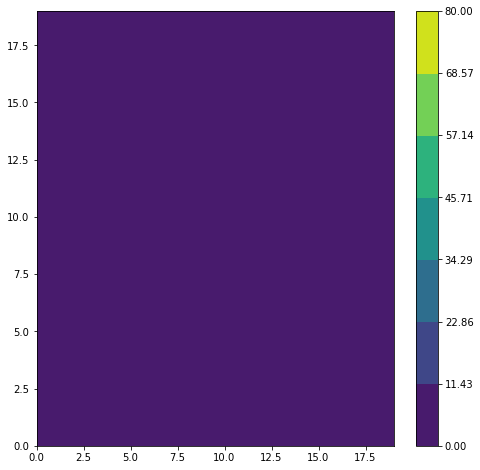

In [21]:
fig, ax = plt.subplots(figsize=(8,8))
den = ax.contourf(np.ones((20,20)), levels = np.linspace(0,80,8))
fig.colorbar(den, ax=ax)

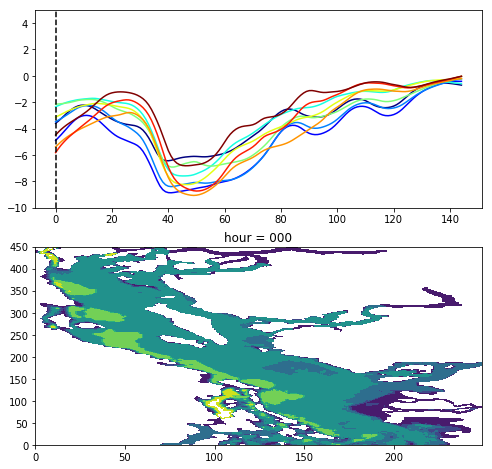

In [15]:
mask_land = 1 - mesh_mask.variables['tmask'][0,0,335:785,115:365]
fig,ax = plt.subplots(2,1,figsize=(8,8))
colours = cm.jet(np.linspace(0,1,9))
def animate30(i):
    ax[0].clear()
    ax[1].clear()
    for p, colour in zip(range(9), colours):
        ax[0].plot(range(145), vwinds2[p], color = colour)
    ax[0].plot((i, i), (-10,5), 'b--', color = 'black')
    ax[0].set_ylim(-10,5)
    masked_depths1 = ma.masked_array(list_of_depths1[i,:,:], mask = mask_land)
    ax[1].contourf(masked_depths1, 
                      levels = np.linspace(0, 80, 8))
    ax[1].set_title('hour = %03d'%(i)) 
    return ax

interval = 0.25#in seconds
ani40 = animation.FuncAnimation(fig,animate30,frames=144,interval=interval*1e+3, repeat=False)
ani40

In [11]:
time_slice = slice('2017-03-21 12:00:00', '2017-03-29 22:00:00')
x_slice = slice(115, 365)
y_slice = slice(335, 785)
sal = (hindcast.salinity
        .isel( gridX=x_slice, gridY=y_slice)
        .sel(time=time_slice))

In [15]:
temp = (hindcast.temperature
         .isel(gridX = x_slice, gridY = y_slice)
         .sel(time=time_slice))

In [13]:
sal_values = sal.values
print(sal_values.shape)

(202, 40, 450, 250)


In [16]:
temp_values = temp.values
print(temp_values.shape)

(202, 40, 450, 250)


In [19]:
density = calc_rho(sal_values, temp_values, depth[np.newaxis,:,np.newaxis, np.newaxis])

In [20]:
rho = 1023.3
index = (np.abs(density - rho)).argmin(axis=1)
list_of_depths = np.zeros((202,450,250))
for t in range(202):
    for y in range(450):
        for x in range(250):
            list_of_depths[t,y,x] = depth[index[t,y,x]]

In [23]:
nemo_ji = np.array([(400, 25), (350,35), (300,40), (240,120), (250,50), (200,120), (150,150), 
                    (100,170), (50,180)]) + (335,115)
grid = xr.open_dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
atmos_grid = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaAtmosphereGridV1')
winds_data = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaSurfaceAtmosphereFieldsV1')

In [39]:
time_slice = slice('2017-03-21 12:00:00', '2017-03-29 22:00:00')
N = 1
Wn = 1/24
B, A = signal.butter(N,Wn)
vwinds = np.zeros((9,203))
i=0
for point in nemo_ji:
    nemo_lon = grid.nav_lon.isel(y=point[0], x=point[1])
    nemo_lat = grid.nav_lat.isel(y=point[0], x=point[1])
    nemo_lon_lat = (np.asscalar(nemo_lon.values), np.asscalar(nemo_lat))
    atmos_ji = geo_tools.find_closest_model_point(
        nemo_lon_lat[0], nemo_lon_lat[1],
        atmos_grid.longitude.values - 360, atmos_grid.latitude.values,
        grid = "GEM2.5")
    u_wind_ts = (winds_data.u_wind
                 .isel(gridY=atmos_ji[0], gridX=atmos_ji[1])
                 .sel(time=time_slice))
    v_wind_ts = (winds_data.v_wind
                 .isel(gridY=atmos_ji[0], gridX=atmos_ji[1])
                 .sel(time=time_slice))
    rotated_u_winds, rotated_v_winds = viz_tools.rotate_vel(u_wind_ts.values, 
                                                       v_wind_ts.values, origin = 'map' )
    windfu = signal.filtfilt(B,A, rotated_u_winds)
    windfv = signal.filtfilt(B,A,rotated_v_winds)
    vwinds[i]=windfv
    i = i + 1

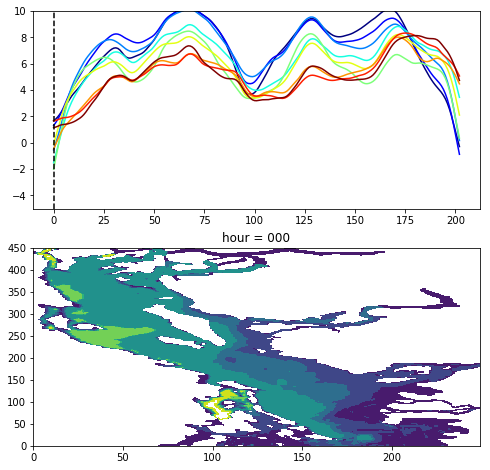

In [59]:
mask_land = 1 - mesh_mask.variables['tmask'][0,0,335:785,115:365]
fig,ax = plt.subplots(2,1,figsize=(8,8))
colours = cm.jet(np.linspace(0,1,9))
def animate30(i):
    ax[0].clear()
    ax[1].clear()
    for p, colour in zip(range(9), colours):
        ax[0].plot(range(203), vwinds[p], color = colour)
    ax[0].plot((i, i), (-5,10), 'b--', color = 'black')
    ax[0].set_ylim(-5,10)
    masked_depths = ma.masked_array(list_of_depths[i,:,:], mask = mask_land)
    ax[1].contourf(masked_depths, 
                      levels = np.linspace(0, 80, 8))
    ax[1].set_title('hour = %03d'%(i)) 
    return ax

interval = 0.25#in seconds
ani40 = animation.FuncAnimation(fig,animate30,frames=202,interval=interval*1e+3, repeat=False)
ani40

In [16]:
time_slice = slice('2017-01-15 12:00:00', '2017-01-20 22:00:00')
x_slice = slice(115, 365)
y_slice = slice(335, 785)
sal = (hindcast.salinity
        .isel( gridX=x_slice, gridY=y_slice)
        .sel(time=time_slice))

In [17]:
temp = (hindcast.temperature
         .isel(gridX = x_slice, gridY = y_slice)
         .sel(time=time_slice))

In [19]:
sal_values = sal.values
temp_values = temp.values

In [20]:
density = calc_rho(sal_values, temp_values, depth[np.newaxis,:,np.newaxis, np.newaxis])

In [21]:
rho = 1023.3
index = (np.abs(density - rho)).argmin(axis=1)
list_of_depths = np.zeros((130,450,250))
for t in range(130):
    for y in range(450):
        for x in range(250):
            list_of_depths[t,y,x] = depth[index[t,y,x]]

In [22]:
time_slice = slice('2017-01-15 12:00:00', '2017-01-20 22:00:00')
N = 1
Wn = 1/24
B, A = signal.butter(N,Wn)
vwinds = np.zeros((9,131))
i=0
for point in nemo_ji:
    nemo_lon = grid.nav_lon.isel(y=point[0], x=point[1])
    nemo_lat = grid.nav_lat.isel(y=point[0], x=point[1])
    nemo_lon_lat = (np.asscalar(nemo_lon.values), np.asscalar(nemo_lat))
    atmos_ji = geo_tools.find_closest_model_point(
        nemo_lon_lat[0], nemo_lon_lat[1],
        atmos_grid.longitude.values - 360, atmos_grid.latitude.values,
        grid = "GEM2.5")
    u_wind_ts = (winds_data.u_wind
                 .isel(gridY=atmos_ji[0], gridX=atmos_ji[1])
                 .sel(time=time_slice))
    v_wind_ts = (winds_data.v_wind
                 .isel(gridY=atmos_ji[0], gridX=atmos_ji[1])
                 .sel(time=time_slice))
    rotated_u_winds, rotated_v_winds = viz_tools.rotate_vel(u_wind_ts.values, 
                                                       v_wind_ts.values, origin = 'map' )
    windfu = signal.filtfilt(B,A, rotated_u_winds)
    windfv = signal.filtfilt(B,A,rotated_v_winds)
    vwinds[i]=windfv
    i = i + 1

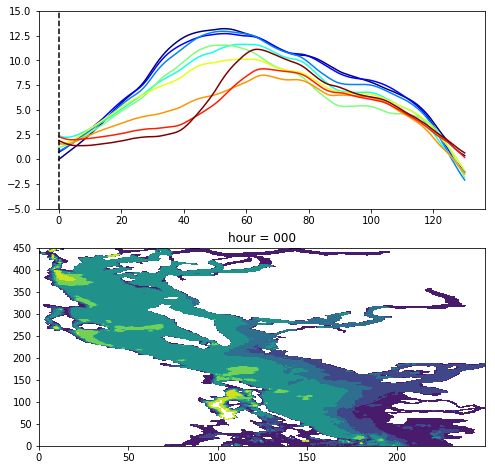

In [24]:
mask_land = 1 - mesh_mask.variables['tmask'][0,0,335:785,115:365]
fig,ax = plt.subplots(2,1,figsize=(8,8))
colours = cm.jet(np.linspace(0,1,9))
def animate30(i):
    ax[0].clear()
    ax[1].clear()
    for p, colour in zip(range(9), colours):
        ax[0].plot(range(131), vwinds[p], color = colour)
    ax[0].plot((i, i), (-5,15), 'b--', color = 'black')
    ax[0].set_ylim(-5,15)
    masked_depths = ma.masked_array(list_of_depths[i,:,:], mask = mask_land)
    ax[1].contourf(masked_depths, 
                      levels = np.linspace(0, 80, 8))
    ax[1].set_title('hour = %03d'%(i)) 
    return ax

interval = 0.25#in seconds
ani40 = animation.FuncAnimation(fig,animate30,frames=130,interval=interval*1e+3, repeat=False)
ani40

In [10]:
hindcast

<xarray.Dataset>
Dimensions:      (depth: 40, gridX: 398, gridY: 898, time: 7296)
Coordinates:
  * time         (time) datetime64[ns] 2016-10-15T00:30:00 ...
  * depth        (depth) float32 0.5 1.5 2.50001 3.50003 4.50007 5.50015 ...
  * gridY        (gridY) int16 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * gridX        (gridX) int16 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
Data variables:
    buoy_n2      (time, depth, gridY, gridX) float64 ...
    salinity     (time, depth, gridY, gridX) float64 ...
    temperature  (time, depth, gridY, gridX) float64 ...
Attributes:
    acknowledgement:           MEOPAR, ONC, Compute Canada
    cdm_data_type:             Grid
    Conventions:               CF-1.6, COARDS, ACDD-1.3
    coverage_content_type:     modelResult
    creator_email:             sallen@eos.ubc.ca
    creator_name:              Salish Sea MEOPAR Project Contributors
    creator_url:               https://salishsea-meopar-docs.readthedocs.io/
    description:  